# ML Project 2
Joseph Bentivegna  
Professor Keene  
10/11/17  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import seaborn as sns

In [3]:
numObs = 20
a0 = -0.3       # Intercept
a1 = 0.5       # Slope
alpha = 2
beta = 25

In [3]:
def update(mean, SD, x, y):
    
    # setup x, y, phi
    x = np.atleast_2d(x)                           #matmul needs 2D
    y = np.atleast_2d(y).transpose()
    mean = np.atleast_2d(mean)
    phi = np.concatenate([np.ones_like(x), x], axis=0)     #makes a vector of [1,X]
    # update mean and cov using baesian multivariate gaussian conjugate prior
    newSD = np.linalg.inv(np.linalg.inv(SD) + beta*np.matmul(phi, phi.transpose()))
    newMean = np.matmul(newSD, np.matmul(np.linalg.inv(SD), mean) + beta*np.matmul(phi, y))
    
    return newMean, newSD

In [4]:
def plotLikelihood(x, y, ax):
    
    # setup dimensions for heatmap
    a = np.arange(-1, 1, 0.01)
    b = np.arange(-1, 1, 0.01)
    Xax, Yax = np.meshgrid(a, b)
    
    # normal pdf (given obs and targ)
    pdf = np.sqrt(beta/(2*np.pi))*(np.exp((-beta/2)*(x - Xax - Yax*y)**2))
    
    # create heatmap
    sns.heatmap(np.flipud(pdf), cmap='jet', cbar=False, xticklabels=False, yticklabels=False, ax=ax)
    
    ax.set_xlabel('w0')
    ax.set_ylabel('w1')
    
    return ax    

In [5]:
def plotGaus(mean, cov, ax):
    
    # Turn arrays into lists (for usage in the multivariate_normal fcn)
    mean = mean.ravel()
    mean = mean.tolist()
    cov = cov.tolist()
    
    # Code taken from scipy documentation for multivarate normals
    x, y = np.mgrid[-1:1:.01, -1:1:.01]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x; 
    pos[:, :, 1] = y
    rv = multivariate_normal(mean, cov)
    
    # Plot contour map
    ax.contourf(x, y, rv.pdf(pos), cmap = 'jet')
    ax.set_xlabel('w0')
    ax.set_ylabel('w1')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    
    # Plot actual point
    ax.scatter(a0, a1, marker='P', color = 'white')
    
    return ax

In [6]:
def plotPosterior(mean, SD, x=None, y=None, ax=None):
    
    # Setup normal distributions from updated mean and SD
    coeff = np.random.multivariate_normal(mean.ravel(), SD, 6)
    
    # Generate line basis values
    space = np.linspace(-1, 1)
    
    # Create lines from distributions
    for i in range(6):
        calc = coeff[i, 0] + coeff[i, 1]*space
        ax.plot(space, calc)
        ax.set_xlabel('w0')
        ax.set_ylabel('w1')
        ax.set_xlim(-1, 1)
        ax.set_ylim(-1, 1)
        
    # Plot observations
    if x is not None and y is not None:
        ax.scatter(x, y)
        
    return ax        

In [7]:
# Generate observations
x = np.random.uniform(-1, 1, numObs)
y = a0 + a1*x + np.random.normal(0, np.sqrt(1/beta), numObs)

# Prior
pMean = np.array([[0], [0]])
pSD = alpha * np.array([[1,0],[0,1]])

# Learning from 1st Obs
m1, SD1 = update(pMean, pSD, x[0], y[0])

# Learning from 2nd Obs
m2, SD2 = update(m1, SD1, x[1], y[1])

# Learning from 20th Obs
m20, SD20 = update(m2, SD2, x[2:], y[2:])

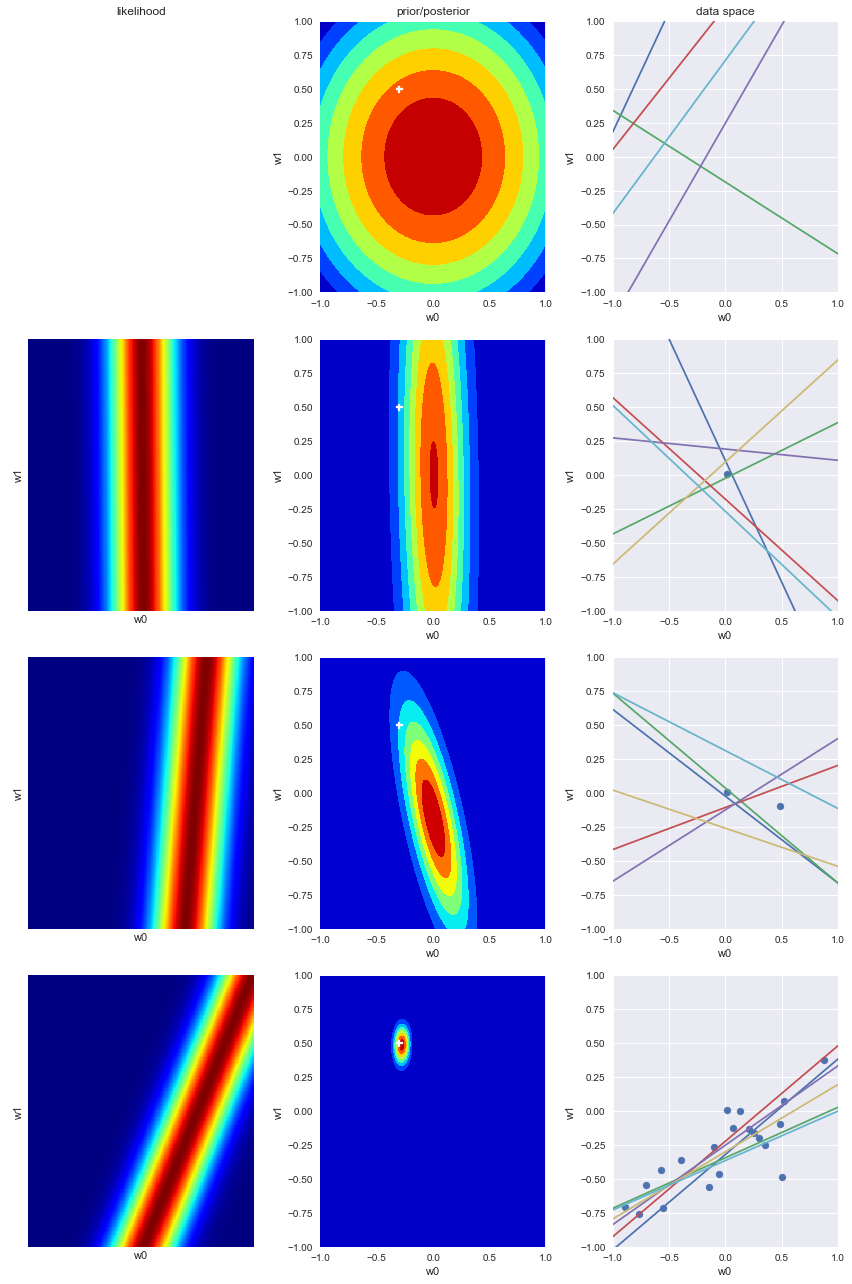

In [8]:
# Plot
figure, axarr = plt.subplots(nrows=4, ncols=3, figsize=[12,18])

# Setup Plot Space
axarr[0, 0].set_title('likelihood')
axarr[0, 1].set_title('prior/posterior')
axarr[0, 2].set_title('data space')
axarr[0, 0].axis('off')

# Plot likelihoods for 1, 2, and 20 samples
plotLikelihood(x[0], y[0], axarr[1, 0])
plotLikelihood(x[1], y[1], axarr[2, 0])
plotLikelihood(x[19], y[19], axarr[3, 0])

# Plot gaussian breakdown
plotGaus(pMean, pSD, axarr[0, 1])
plotGaus(m1, SD1, axarr[1, 1])
plotGaus(m2, SD2, axarr[2, 1])
plotGaus(m20, SD20, axarr[3, 1])

# Plot the posterior data space
plotPosterior(pMean, pSD, ax = axarr[0, 2])
plotPosterior(m1, SD1, x[0], y[0], axarr[1, 2])
plotPosterior(m2, SD2, x[:2], y[:2], axarr[2, 2])
plotPosterior(m20, SD20, x, y, axarr[3, 2])

plt.tight_layout()
sns.despine(figure)
plt.show()